In [1]:
import numpy as np
import torch, torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import variable
from torch import functional as F
import random
from tqdm.auto import tqdm

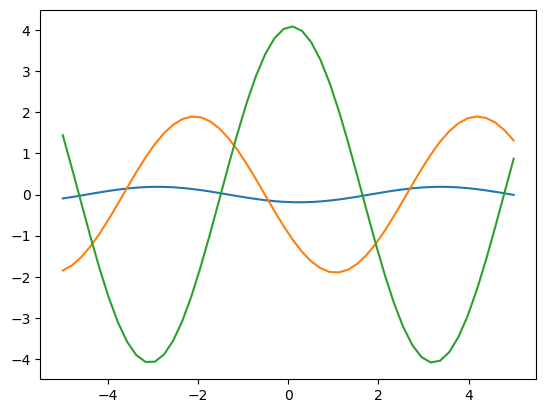

In [2]:

class SineWaveTask:
    def __init__(self):
        self.a = np.random.uniform(0.1, 5.0)
        self.b = np.random.uniform(1, 2*np.pi)
        self.train_x = None
    
    def f(self, x):
        return self.a * np.sin(x + self.b)


    def train_set(self, size=10, force_new=False):
        if self.train_x is None and not force_new:
            self.train_x = np.random.uniform(-5, 5, size)
            x = self.train_x
        elif not force_new:
            x = self.train_x
        else:
            x = np.random.uniform(-5, 5, size)
        
        y = self.f(x)
        return torch.Tensor(x), torch.Tensor(y)
    
    def test_set(self, size=50):
        x = np.linspace(-5, 5, size)
        y = self.f(x)
        return torch.Tensor(x), torch.Tensor(y)
    
    def plot(self, *args, **kwargs):
        x, y = self.test_set()
        return plt.plot(x.cpu().detach().numpy(), y.cpu().detach().numpy(), *args, **kwargs)


SineWaveTask().plot()
SineWaveTask().plot()
SineWaveTask().plot()
plt.show()

In [4]:

class sineModel(nn.Module):
    def __init__(self):
        super(sineModel, self).__init__()
        self.linear1 = nn.Linear(1, 40)
        self.linear2 = nn.Linear(40, 40)
        self.out = nn.Linear(40, 1)
    
    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        return self.out(x)


    def forward_sp(self, x, weight_dict):
        self.load_state_dict(weight_dict)
        return self.forward(x)


TRAIN_SIZE = 10000
TEST_SIZE = 1000
SINE_TRAIN = [SineWaveTask() for _ in range(TRAIN_SIZE)]
SINE_TEST = [SineWaveTask() for _ in range(TEST_SIZE)]
sine_model = sineModel()
# sine_model.state_dict()

def sine_fit1(net, wave, optim=None, force_new=False, create_graph=False):
    loss_ = nn.MSELoss()
    net.train()
    if optim is not None:
        optim.zero_grad()
    
    x, y = wave.train_set(force_new=force_new)
    loss = loss_(net(torch.Tensor(x[:, None])), torch.Tensor(y.reshape(-1, 1)))
    loss.backward(create_graph=create_graph, retain_graph=True)
    if optim is not None:
        optim.step()
    return loss

def fit_transfer(epochs=1):
    optim = torch.optim.Adam(sine_model.parameters())
    for ep_i in range(epochs):
        tqd_bar = tqdm(random.sample(SINE_TRAIN, len(SINE_TRAIN)))
        tqd_bar.set_description(f'[ {ep_i+1:02d} / {epochs:02d} ]')
        for t in tqd_bar:
            loss = sine_fit1(sine_model, t, optim)
            loss = loss.cpu().detach().numpy()
            tqd_bar.set_postfix({'loss': f'{loss:.3f}'})


fit_transfer()

  0%|          | 0/10000 [00:00<?, ?it/s]

# MAML

In [5]:
def maml_sine(model, epochs, lr_inner=0.01, batch_size=1, first_order=False):
    opt = torch.optim.Adam(model.parameters())
    for ep_i in range(epochs):
        tqd_bar = tqdm(enumerate(random.sample(SINE_TRAIN, len(SINE_TRAIN))), total=len(SINE_TRAIN))
        tqd_bar.set_description(f'[ {ep_i+1:02d} / {epochs:02d} ]')
        set_params = {}
        for i, t in tqd_bar:
            new_model = sineModel()
            new_model.load_state_dict(model.state_dict())
            loss = sine_fit1(new_model, t, create_graph=not first_order)
            for name, param in new_model.named_parameters():
                grad = param.grad
                if first_order:
                    grad = variable(grad.detach().data)
                set_params[name] = param - lr_inner * grad
            
            new_model.load_state_dict(set_params)
            sine_fit1(new_model, t, force_new=True)
            loss_ = loss.cpu().detach().numpy()
            tqd_bar.set_postfix({'loss': f'{loss_:.3f}'})
            if (i + 1) % batch_size == 0:
                opt.step()
                opt.zero_grad()

SINE_MAML = [sineModel() for _ in range(5)]


for m in SINE_MAML:
    maml_sine(m, 4)

  0%|          | 0/10000 [00:00<?, ?it/s]

/home/scc/anaconda3/envs/sccRL/lib/python3.10/site-packages/torch/autograd/__init__.py:200: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1151.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]